# The notebook explores transformations on the target data which are typical in segmentation task.

This notebook is based on this link: https://albumentations.ai/docs/examples/example_kaggle_salt/

In [10]:
import imp
import cv2
import random
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt

/tmp/ipykernel_17737/1875989997.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


Define a function to visualize images and masks

In [4]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

Read an image and its mask from the disk

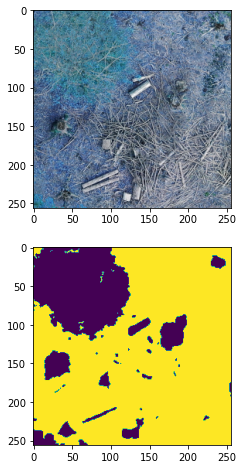

In [16]:
image = cv2.imread('../Images/Rasterio_windowing/rgb/1_5.png')
mask = cv2.imread('../Images/Rasterio_windowing/mask/1_5.png', cv2.IMREAD_GRAYSCALE)
original_height, original_width = image.shape[:2]

visualize(image, mask)

U-Net type architectures require input image size be divisible by 2^N, where N is the number of maxpooling layers. 
In this case, the resolution of the images is 255x255 which is fine for any U-Net architecture which has equal or less than 8 maxpooling layers.

In other case, the images should be transfored to an appropriate resolution that is dividable by 2^N. This operation may be performed using PadIfNeeded transformation. It pads both the image and the mask on all four sides. Padding type (zero, constant, reflection) may be specified. The default padding is reflection padding.

(256, 256, 3) (256, 256)


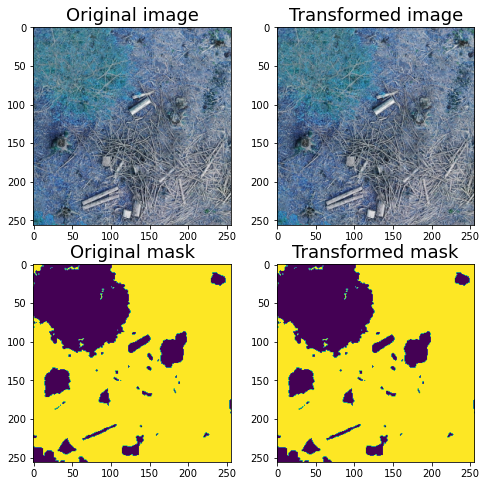

In [17]:
aug = A.PadIfNeeded(min_height=128, min_width=128, p=1)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)

visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

We can get back the original image from the padded version by using the CenterCrop or Crop function. In this case, the results are the same again.

(256, 256, 3) (256, 256)


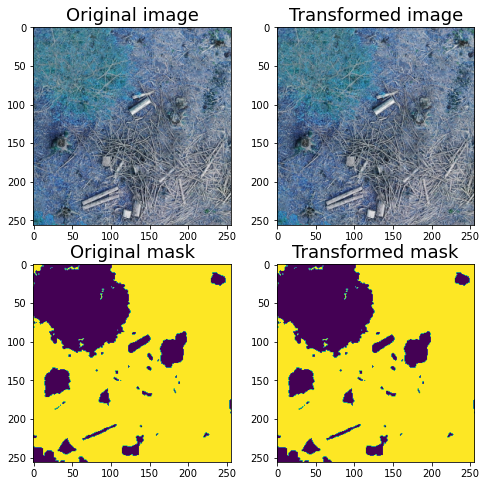

In [18]:
aug = A.CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize(image_padded, mask_padded, original_image=image_center_cropped, original_mask=mask_center_cropped)

**1. HorizontalFlip**

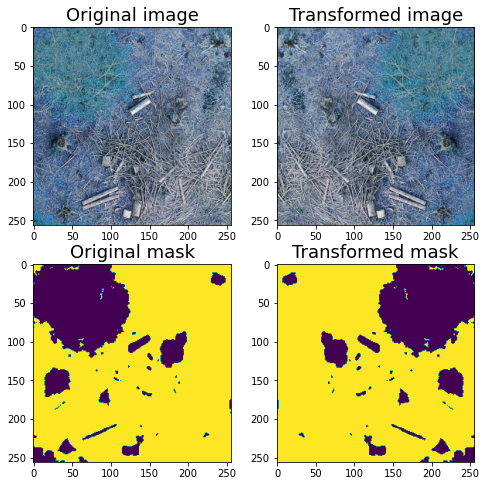

In [19]:
aug = A.HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

**2. VerticalFlip**

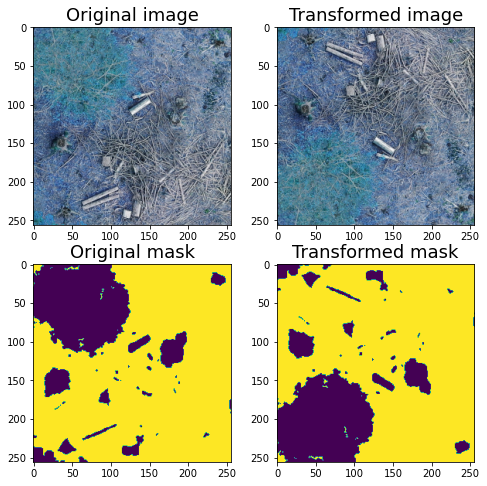

In [20]:
aug = A.VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

**3. RandomRotate90 (Randomly rotates by 0, 90, 180, 270 degrees)**

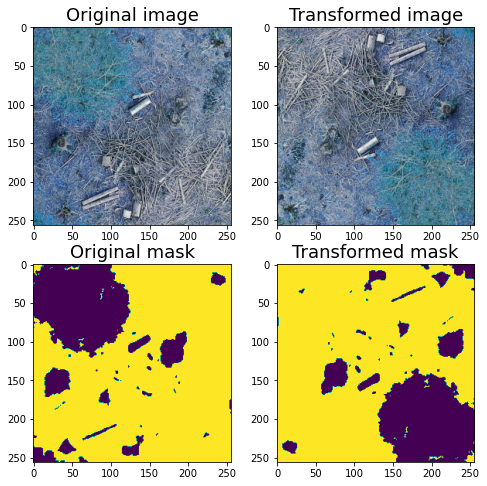

In [21]:

aug = A.RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

**4. Transpose (switch X and Y axis)**

For some reason, it does not change the input image

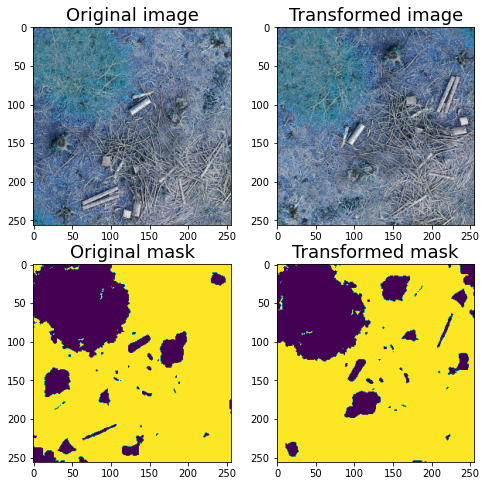

In [23]:
aug = A.Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

**5. ElasticTransform**

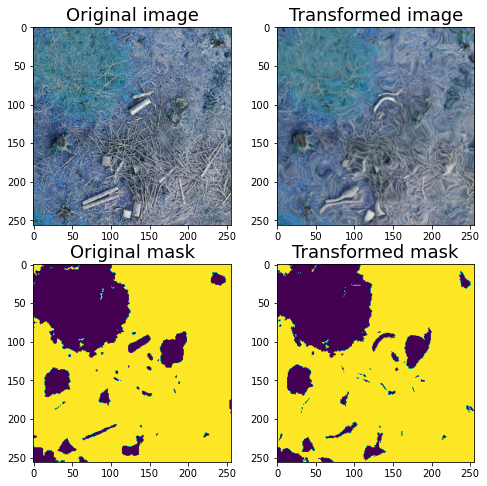

In [24]:
aug = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

**6. Grid distortion**

The modifications are barely visible, but you can spot them at the bottom left and top right corner.

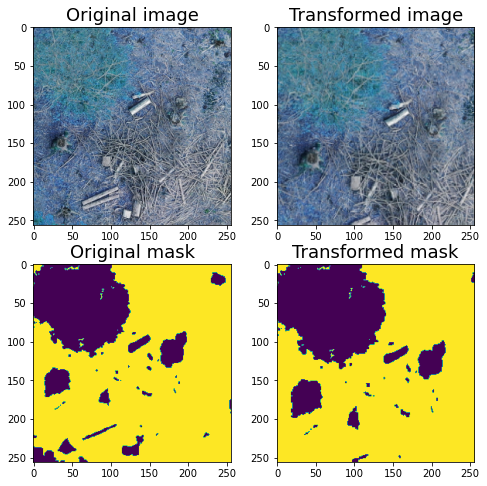

In [25]:
aug = A.GridDistortion(p=1)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize(image_grid, mask_grid, original_image=image, original_mask=mask)

**7. OpticalDistortion**

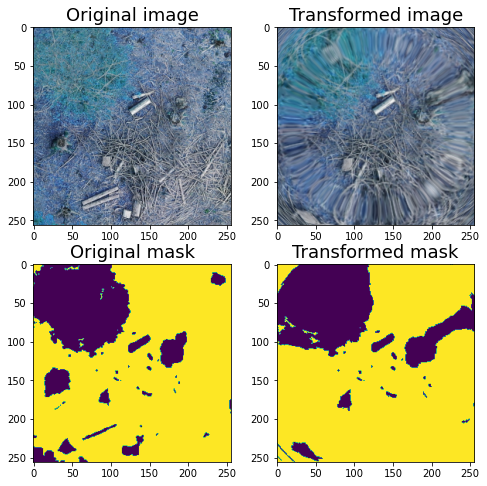

In [26]:
aug = A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_optical = augmented['image']
mask_optical = augmented['mask']

visualize(image_optical, mask_optical, original_image=image, original_mask=mask)

**8. RandomSizedCrop**

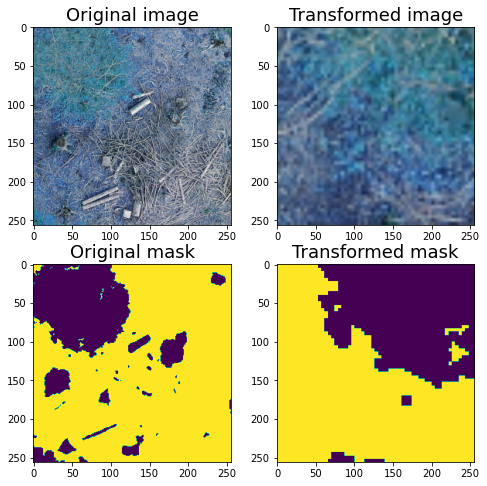

In [27]:
aug = A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=1)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

**9. Combining different transformations**

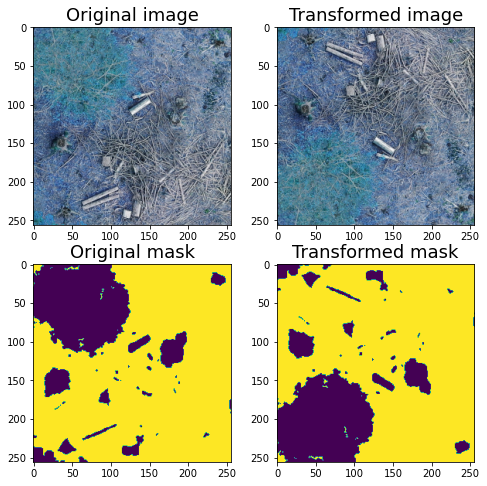

In [28]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5)]
)

random.seed(7)
augmented = aug(image=image, mask=mask)

image_light = augmented['image']
mask_light = augmented['mask']

visualize(image_light, mask_light, original_image=image, original_mask=mask)

**11. Add more transformations**

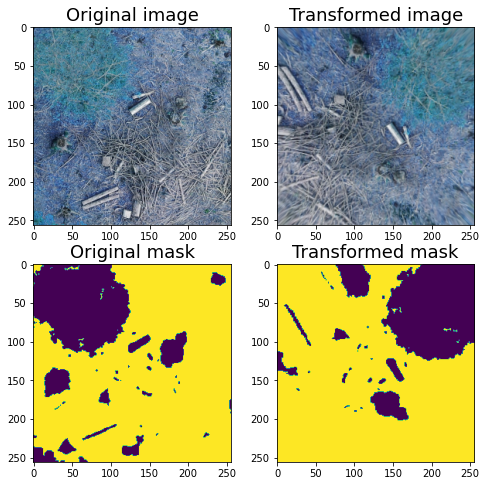

In [29]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ],p=1),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8)])

random.seed(11)
augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize(image_medium, mask_medium, original_image=image, original_mask=mask)

**12. And even more transformation**

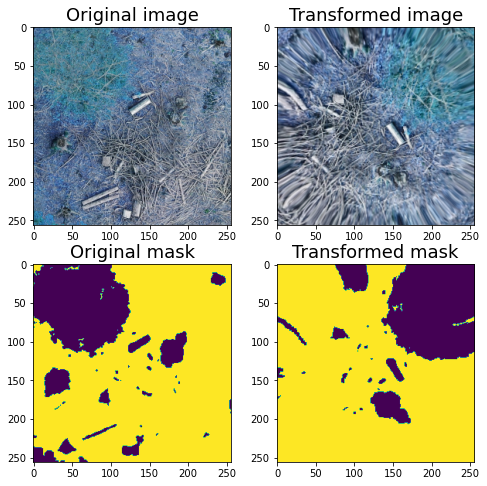

In [30]:
aug = A.Compose([
    A.OneOf([
        A.RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ], p=1),    
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)])

random.seed(11)
augmented = aug(image=image, mask=mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)